In [1]:
!pip install pykrx statsmodels scikit-learn pandas numpy matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 88.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.7/264.7 kB 22.1 MB/s eta 0:00:00


정확도: 0.5084
[[52 45]
 [43 39]]
              precision    recall  f1-score   support

           0     0.5474    0.5361    0.5417        97
           1     0.4643    0.4756    0.4699        82

    accuracy                         0.5084       179
   macro avg     0.5058    0.5058    0.5058       179
weighted avg     0.5093    0.5084    0.5088       179



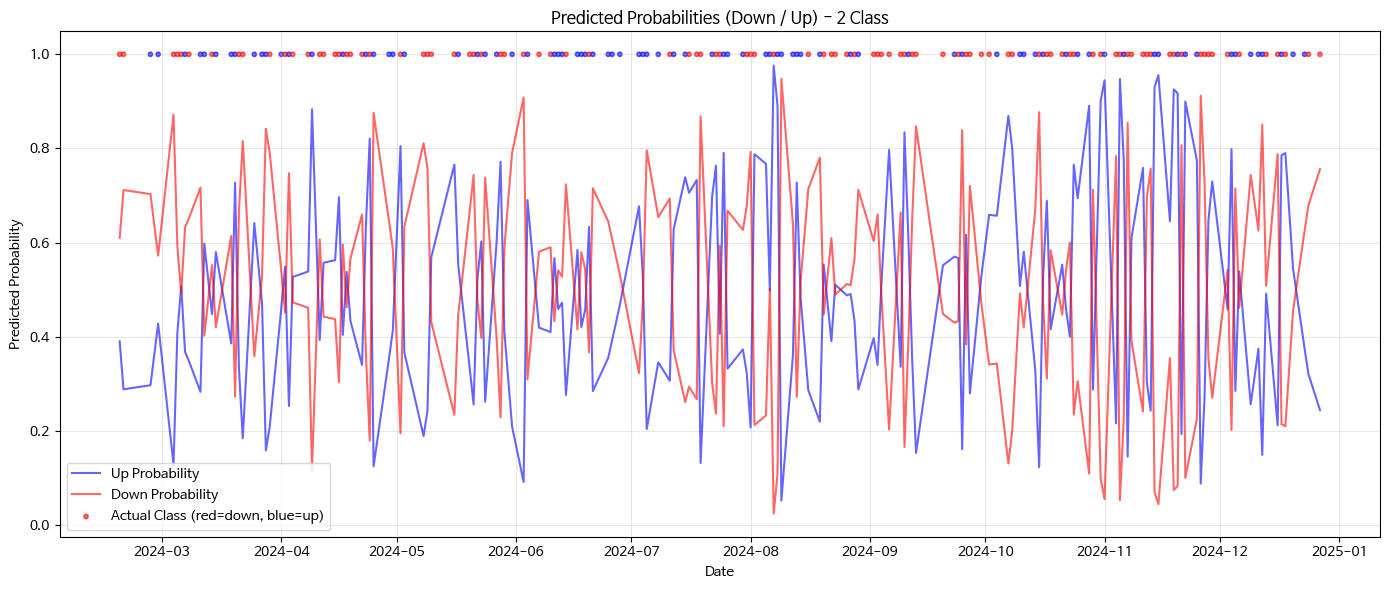

In [2]:
# 2-class classification (up, down)

from pykrx import stock
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. 데이터 불러오기
start_date = "20220101"
end_date = "20241231"
ticker_code = "005930"  # 삼성전자
window_size = 5

OHLCV = stock.get_market_ohlcv_by_date(start_date, end_date, ticker_code)
data = OHLCV[['시가', '고가', '저가', '종가', '거래량']].copy()
data.columns = ['open', 'high', 'low', 'close', 'volume']

# 2. Feature Engineering
data['body'] = abs((data['close'] - data['open']) / data['open']) * 100
data['upper_shadow'] = (data['high'] - data[['open', 'close']].max(axis=1)) / data['open'] * 100
data['lower_shadow'] = (data[['open', 'close']].min(axis=1) - data['low']) / data['open'] * 100

# 0으로 나누는 위험 방지용 epsilon
eps = 1e-9
range_hl = (data['high'] - data['low']).replace(0, np.nan)

data['body_ratio'] = abs(data['close'] - data['open']) / (range_hl + eps)
data['shadow_ratio'] = (data['upper_shadow'] - data['lower_shadow']) / (((range_hl / data['open']) * 100) + eps)

data['direction'] = np.sign(data['close'] - data['open'])
data['volume_strength'] = data['volume'] / data['volume'].rolling(5).mean()
data['momentum'] = (data['close'] - data['close'].shift(1)) / data['close'].shift(1) * 100

# 3. 라벨링 (2-class)
data['next_close'] = data['close'].shift(-1)
data['return'] = (data['next_close'] - data['close']) / data['close'] * 100

threshold = 0.3  # ±0.3% 이내는 제외

# Down=0, Up=1, 그 외(중립)는 NaN 처리 후 제거
data['label'] = np.where(
    data['return'] < -threshold, 0,
    np.where(data['return'] > threshold, 1, np.nan)
)

# 4. 시계열 feature 추가
features = [
    'body', 'upper_shadow', 'lower_shadow', 'body_ratio',
    'shadow_ratio', 'direction', 'volume_strength', 'momentum'
]

for col in features:
    for i in range(1, window_size + 1):
        data[f'{col}_{i}_days_ago'] = data[col].shift(i)

# 라벨/피처 결측 제거
data.dropna(inplace=True)

# 5. Train/Test Split
x = data.filter(regex='_days_ago$')
y = data['label'].astype(int)

train_size = int(len(x) * 0.7)
x_train, x_test = x.iloc[:train_size], x.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# 6. Binary Logistic Regression
model = LogisticRegression(max_iter=1000)
model.fit(x_train_scaled, y_train)

y_pred = model.predict(x_test_scaled)
y_prob = model.predict_proba(x_test_scaled)  # [:, 1] 이 Up 확률

# 7. 평가
print(f"정확도: {accuracy_score(y_test, y_pred):.4f}")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=4))

# 8. 시각화 (Up/Down 확률)
plt.figure(figsize=(14, 6))

up_prob = y_prob[:, 1]
down_prob = y_prob[:, 0]

plt.plot(y_test.index, up_prob, color='blue', alpha=0.6, label='Up Probability')
plt.plot(y_test.index, down_prob, color='red', alpha=0.6, label='Down Probability')

# 실제 라벨 표시 (위쪽에 점으로)
colors = y_test.map({0: 'red', 1: 'blue'})
plt.scatter(y_test.index, [1]*len(y_test), c=colors, s=10, alpha=0.6,
            label='Actual Class (red=down, blue=up)')

plt.title('Predicted Probabilities (Down / Up) - 2 Class')
plt.xlabel('Date')
plt.ylabel('Predicted Probability')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


정확도: 0.4450
[[51  9 40]
 [14  5 14]
 [39  5 41]]
              precision    recall  f1-score   support

           0     0.4904    0.5100    0.5000       100
           1     0.2632    0.1515    0.1923        33
           2     0.4316    0.4824    0.4556        85

    accuracy                         0.4450       218
   macro avg     0.3950    0.3813    0.3826       218
weighted avg     0.4331    0.4450    0.4361       218



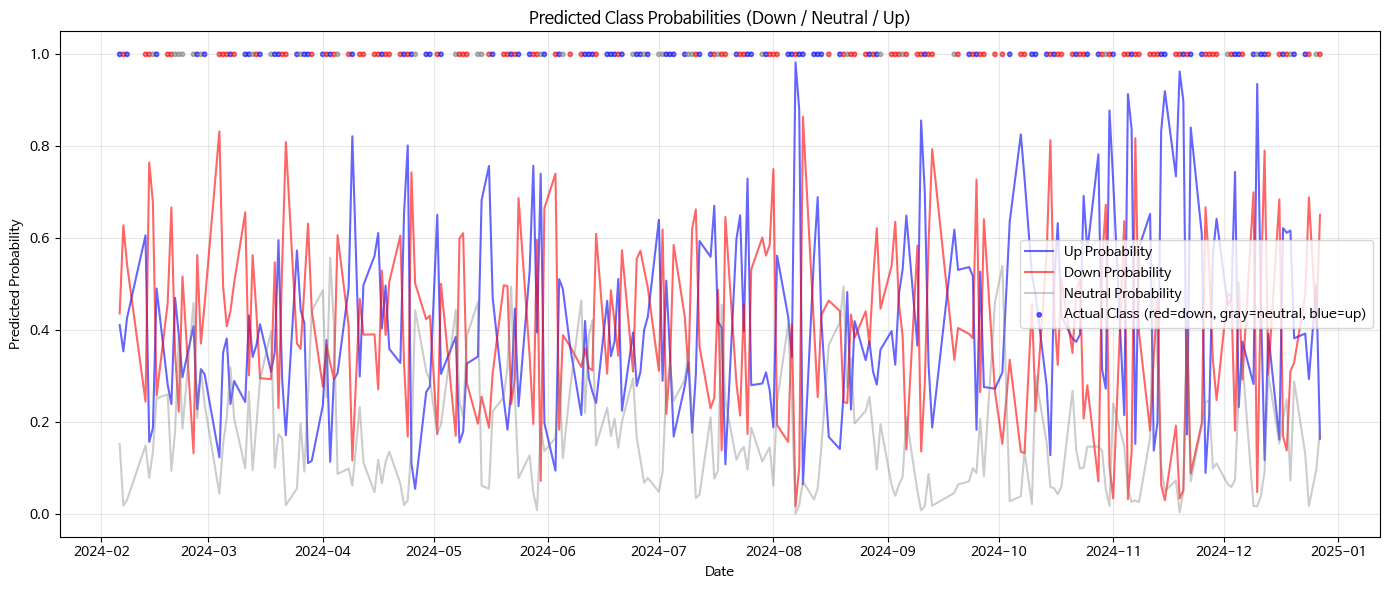

In [3]:
# 3-class classification (up, down, neutral)

from pykrx import stock
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. 데이터 불러오기
start_date = "20220101"
end_date = "20241231"
ticker_code = "005930"  # 삼성전자
window_size = 5

OHLCV = stock.get_market_ohlcv_by_date(start_date, end_date, ticker_code)
data = OHLCV[['시가', '고가', '저가', '종가', '거래량']]
data.columns = ['open', 'high', 'low', 'close', 'volume']

# 2. Feature Engineering
data['body'] = abs((data['close'] - data['open']) / data['open']) * 100
data['upper_shadow'] = (data['high'] - data[['open', 'close']].max(axis=1)) / data['open'] * 100
data['lower_shadow'] = (data[['open', 'close']].min(axis=1) - data['low']) / data['open'] * 100
data['body_ratio'] = abs(data['close'] - data['open']) / (data['high'] - data['low'])
data['shadow_ratio'] = (data['upper_shadow'] - data['lower_shadow']) / ((data['high'] - data['low']) / data['open'] * 100)
data['direction'] = np.sign(data['close'] - data['open'])
data['volume_strength'] = data['volume'] / data['volume'].rolling(5).mean()
data['momentum'] = (data['close'] - data['close'].shift(1)) / data['close'].shift(1) * 100

# 3. 라벨링 (3-class)
data['next_close'] = data['close'].shift(-1)
data['return'] = (data['next_close'] - data['close']) / data['close'] * 100

threshold = 0.3  # ±0.3% 이내는 변동 미미로 간주
conditions = [
    data['return'] < -threshold,                 # 하락
    (data['return'] >= -threshold) & (data['return'] <= threshold),  # 변동 미미
    data['return'] > threshold                   # 상승
]
choices = [0, 1, 2]
data['label'] = np.select(conditions, choices)

# 4. 시계열 feature 추가
features = ['body', 'upper_shadow', 'lower_shadow', 'body_ratio',
            'shadow_ratio', 'direction', 'volume_strength', 'momentum']

for col in features:
    for i in range(1, window_size + 1):
        data[f'{col}_{i}_days_ago'] = data[col].shift(i)

data.dropna(inplace=True)

# 5. Train/Test Split
x = data.filter(regex='_days_ago$')
y = data['label']

train_size = int(len(x) * 0.7)
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# 6. Multinomial Logistic Regression
model = LogisticRegression(max_iter=1000, multi_class='multinomial')
model.fit(x_train_scaled, y_train)
y_pred = model.predict(x_test_scaled)
y_prob = model.predict_proba(x_test_scaled)

# 7. 평가
print(f"정확도: {accuracy_score(y_test, y_pred):.4f}")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=4))

# 8. 시각화
plt.figure(figsize=(14, 6))
plt.plot(y_test.index, y_prob[:, 2], color='blue', alpha=0.6, label='Up Probability')
plt.plot(y_test.index, y_prob[:, 0], color='red', alpha=0.6, label='Down Probability')
plt.plot(y_test.index, y_prob[:, 1], color='gray', alpha=0.4, label='Neutral Probability')

# 실제 구간 색상 표시
colors = y_test.map({0: 'red', 1: 'gray', 2: 'blue'})
plt.scatter(y_test.index, [1]*len(y_test), c=colors, s=10, alpha=0.6, label='Actual Class (red=down, gray=neutral, blue=up)')

plt.title('Predicted Class Probabilities (Down / Neutral / Up)')
plt.xlabel('Date')
plt.ylabel('Predicted Probability')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
# additional feature (SMA, RSI, MACD)
from pykrx import stock
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Indicator 계산 함수들
def add_sma_features(df, windows=(5, 10, 20)):
    df = df.copy()
    for w in windows:
        df[f'sma_{w}'] = df['close'].rolling(w).mean()
        # 가격 대비 SMA 괴리율(%)
        df[f'sma_{w}_dist'] = (df['close'] - df[f'sma_{w}']) / df[f'sma_{w}'] * 100
    return df


def add_macd_features(df, fast=12, slow=26, signal=9):
    df = df.copy()
    ema_fast = df['close'].ewm(span=fast, adjust=False).mean()
    ema_slow = df['close'].ewm(span=slow, adjust=False).mean()
    df['macd'] = ema_fast - ema_slow
    df['macd_signal'] = df['macd'].ewm(span=signal, adjust=False).mean()
    df['macd_hist'] = df['macd'] - df['macd_signal']
    return df


def add_rsi_features(df, period=14):
    df = df.copy()
    delta = df['close'].diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)

    # Wilder 방식에 가까운 EWM 기반
    avg_gain = gain.ewm(alpha=1/period, adjust=False).mean()
    avg_loss = loss.ewm(alpha=1/period, adjust=False).mean()

    rs = avg_gain / (avg_loss + 1e-9)
    df['rsi'] = 100 - (100 / (1 + rs))
    return df


# 베이스 Feature Engineering
def add_base_features(df):
    df = df.copy()

    df['body'] = abs((df['close'] - df['open']) / df['open']) * 100
    df['upper_shadow'] = (df['high'] - df[['open', 'close']].max(axis=1)) / df['open'] * 100
    df['lower_shadow'] = (df[['open', 'close']].min(axis=1) - df['low']) / df['open'] * 100

    eps = 1e-9
    range_hl = (df['high'] - df['low']).replace(0, np.nan)

    df['body_ratio'] = abs(df['close'] - df['open']) / (range_hl + eps)
    df['shadow_ratio'] = (df['upper_shadow'] - df['lower_shadow']) / (((range_hl / df['open']) * 100) + eps)

    df['direction'] = np.sign(df['close'] - df['open'])
    df['volume_strength'] = df['volume'] / df['volume'].rolling(5).mean()
    df['momentum'] = (df['close'] - df['close'].shift(1)) / df['close'].shift(1) * 100

    return df


# 라벨 생성
def add_labels(df, threshold=0.3, label_mode="triple"):
    """
    label_mode:
      - "triple": Down=0, Neutral=1, Up=2
      - "binary": Neutral 제거, Down=0, Up=1
    """
    df = df.copy()
    df['next_close'] = df['close'].shift(-1)
    df['return'] = (df['next_close'] - df['close']) / df['close'] * 100

    if label_mode == "triple":
        conditions = [
            df['return'] < -threshold,
            (df['return'] >= -threshold) & (df['return'] <= threshold),
            df['return'] > threshold
        ]
        choices = [0, 1, 2]
        df['label'] = np.select(conditions, choices)

    elif label_mode == "binary":
        # 중립은 NaN으로 두고 제거
        df['label'] = np.where(
            df['return'] < -threshold, 0,
            np.where(df['return'] > threshold, 1, np.nan)
        )
    else:
        raise ValueError("label_mode must be 'triple' or 'binary'")

    return df


# 시계열 lag feature 생성
def add_lag_features(df, feature_cols, window_size=5):
    df = df.copy()
    for col in feature_cols:
        for i in range(1, window_size + 1):
            df[f'{col}_{i}_days_ago'] = df[col].shift(i)
    return df


# 전체 파이프라인
def prepare_dataset(
    start_date="20220101",
    end_date="20241231",
    ticker_code="005930",
    window_size=5,
    threshold=0.3,
    label_mode="triple",
    indicator=None
):
    # OHLCV 로드
    OHLCV = stock.get_market_ohlcv_by_date(start_date, end_date, ticker_code)
    df = OHLCV[['시가', '고가', '저가', '종가', '거래량']].copy()
    df.columns = ['open', 'high', 'low', 'close', 'volume']

    # 베이스 피처
    df = add_base_features(df)

    # 지표 추가
    if indicator == "sma":
        df = add_sma_features(df, windows=(5, 10, 20))
    elif indicator == "macd":
        df = add_macd_features(df, fast=12, slow=26, signal=9)
    elif indicator == "rsi":
        df = add_rsi_features(df, period=14)
    elif indicator is None:
        pass
    else:
        raise ValueError("indicator must be one of: None, 'sma', 'macd', 'rsi'")

    # 라벨
    df = add_labels(df, threshold=threshold, label_mode=label_mode)

    # 어떤 컬럼을 lag 대상으로 쓸지 결정
    base_feature_cols = [
        'body', 'upper_shadow', 'lower_shadow', 'body_ratio',
        'shadow_ratio', 'direction', 'volume_strength', 'momentum'
    ]

    indicator_cols = []
    if indicator == "sma":
        indicator_cols = ['sma_5', 'sma_10', 'sma_20', 'sma_5_dist', 'sma_10_dist', 'sma_20_dist']
    elif indicator == "macd":
        indicator_cols = ['macd', 'macd_signal', 'macd_hist']
    elif indicator == "rsi":
        indicator_cols = ['rsi']

    feature_cols = base_feature_cols + indicator_cols

    # lag 생성
    df = add_lag_features(df, feature_cols, window_size=window_size)

    # 결측 제거
    df.dropna(inplace=True)

    # X/Y 구성
    X = df.filter(regex='_days_ago$')
    y = df['label']

    if label_mode == "binary":
        y = y.astype(int)

    return df, X, y


# 학습/평가/시각화
def run_experiment(
    label_mode="triple",
    indicator=None,
    start_date="20220101",
    end_date="20241231",
    ticker_code="005930",
    window_size=5,
    threshold=0.3,
    train_ratio=0.7,
    show_plot=True
):
    df, X, y = prepare_dataset(
        start_date=start_date,
        end_date=end_date,
        ticker_code=ticker_code,
        window_size=window_size,
        threshold=threshold,
        label_mode=label_mode,
        indicator=indicator
    )

    # 시계열 분할
    train_size = int(len(X) * train_ratio)
    X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
    y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # 모델
    # - triple: multinomial
    # - binary: default binary logistic
    if label_mode == "triple":
        model = LogisticRegression(max_iter=2000, multi_class='multinomial')
    else:
        model = LogisticRegression(max_iter=2000)

    model.fit(X_train_scaled, y_train)

    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)

    # 평가 출력
    title = f"[{label_mode.upper()}] + {indicator.upper() if indicator else 'BASE'}"
    print("=" * 80)
    print(title)
    print(f"Samples: train={len(X_train)}, test={len(X_test)}")
    print(f"정확도: {accuracy_score(y_test, y_pred):.4f}")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred, digits=4))

    # 시각화
    if show_plot:
        plt.figure(figsize=(14, 6))

        if label_mode == "binary":
            up_prob = y_prob[:, 1]
            down_prob = y_prob[:, 0]

            plt.plot(y_test.index, up_prob, color='blue', alpha=0.6, label='Up Probability')
            plt.plot(y_test.index, down_prob, color='red', alpha=0.6, label='Down Probability')

            colors = y_test.map({0: 'red', 1: 'blue'})
            plt.scatter(
                y_test.index, [1]*len(y_test),
                c=colors, s=10, alpha=0.6,
                label='Actual (red=down, blue=up)'
            )

            plt.title(f'Predicted Probabilities (Down/Up) - {title}')

        else:
            # triple
            plt.plot(y_test.index, y_prob[:, 2], color='blue', alpha=0.6, label='Up Probability')
            plt.plot(y_test.index, y_prob[:, 0], color='red', alpha=0.6, label='Down Probability')
            plt.plot(y_test.index, y_prob[:, 1], color='gray', alpha=0.4, label='Neutral Probability')

            colors = y_test.map({0: 'red', 1: 'gray', 2: 'blue'})
            plt.scatter(
                y_test.index, [1]*len(y_test),
                c=colors, s=10, alpha=0.6,
                label='Actual (red=down, gray=neutral, blue=up)'
            )

            plt.title(f'Predicted Class Probabilities (Down/Neutral/Up) - {title}')

        plt.xlabel('Date')
        plt.ylabel('Predicted Probability')
        plt.legend()
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

    return {
        "df": df,
        "X": X,
        "y": y,
        "model": model,
        "scaler": scaler,
    }



In [ ]:
# 2-class + SMA
run_experiment(label_mode="binary", indicator="sma")

In [ ]:
# 2-class + MACD
run_experiment(label_mode="binary", indicator="macd")

In [ ]:
# 2-class + RSI
run_experiment(label_mode="binary", indicator="rsi")

In [ ]:
# 3-class + SMA
run_experiment(label_mode="triple", indicator="sma")

In [ ]:
# 3-class + MACD
run_experiment(label_mode="triple", indicator="macd")

In [ ]:
# 3-class + RSI
run_experiment(label_mode="triple", indicator="rsi")